In [1]:
%matplotlib inline


用基于注意力机制的seq2seq神经网络进行翻译
*************************************************************
**作者**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

这个教程主要讲解用一个神经网络将法语翻译成英语.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... 取得不同阶段的成功.

这是通过`seq2seq网络 <http://arxiv.org/abs/1409.3215>`__实现的简单却强大的想法,
通过两个递归神经网络一起工作实现将一个序列转换为另一个.一个编码器网络将输入序列压
缩成向量,解码器网络将该矢量展开为新的序列.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:
   
为了改进这个模型,我们将使用一种`注意力机制<https://arxiv.org/abs/1409.0473>`__,
它可以让解码器学习将注意力集中在输入序列的特定范围上.

**推荐阅读:**

我们假设你至少已经安装了PyTorch,了解Python,并且了解张量:

-  http://pytorch.org/ PyTorch安装说明
-  :doc:`/beginner/deep_learning_60min_blitz` 开始使用PyTorch
-  :doc:`/beginner/pytorch_with_examples` 进行广泛而深入的了解
-  :doc:`/beginner/former_torchies_tutorial` 如果你是前Lua Torch用户


这些内容也有利于了解seq2seq网络和其工作机制:

-  `用RNN编码器 - 解码器来学习用于统计机器翻译的短语表示 <http://arxiv.org/abs/1406.1078>`__
-  `用神经网络进行seq2seq学习 <http://arxiv.org/abs/1409.3215>`__
-  `神经网络机器翻译联合学习对齐和翻译 <https://arxiv.org/abs/1409.0473>`__
-  `神经会话模型 <http://arxiv.org/abs/1506.05869>`__

你还可以找到以前的教程关于Character-Level RNN名称分类
:doc:`/intermediate/char_rnn_classification_tutorial`
和生成名称 :doc:`/intermediate/char_rnn_generation_tutorial`
这些概念与编码器和解码器模型非常相似.

更多内容请阅读介绍这些主题的论文:

-  `用RNN编码器 - 解码器来学习用于统计机器翻译的短语表示 <http://arxiv.org/abs/1406.1078>`__
-  `用神经网络进行seq2seq学习 <http://arxiv.org/abs/1409.3215>`__
-  `神经网络机器翻译联合学习对齐和翻译 <https://arxiv.org/abs/1409.0473>`__
-  `神经会话模型 <http://arxiv.org/abs/1506.05869>`__


**要求**



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

加载数据文件
==================

这个项目的数据是一组数以千计的英语到法语的翻译对.

`这个问题在 Open Data Stack Exchange上
 <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
指导我们使用开放的翻译网站 http://tatoeba.org/ 可下载地址为 http://tatoeba.org/eng/downloads - 更好的是,
有人做了额外的工作,切分语言对到单个文本文件中: http://www.manythings.org/anki/

英文到法文对太大而不能包含在repo中,因此开始前请下载
 ``data/eng-fra.txt``. 该文件是一个制表符分隔的翻译对列表: :

::

    I am cold.    Je suis froid.

.. Note::
   下载数据文件在
   `这里 <https://download.pytorch.org/tutorial/data.zip>`_
   并解压到正确的路径.



与character-level RNN教程中使用的字符编码类似,我们将用语言中的每个单词
作为独热向量,或者除了单个单词之外(在单词的索引处)的大的零向量. 相较于可能
存在于一种语言中仅有十个字符相比,多数都是有大量的字,因此编码向量很大. 
然而,我们会欺骗性的做一些数据修剪,保证每种语言只使用几千字.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





我们需要每个单词对应唯一的索引作为稍后的网络输入和目标.为了追踪这些索引我们使用一个帮助类
 ``Lang`` 类中有 词 → 索引 (``word2index``) 和 索引 → 词
(``index2word``) 的字典, 以及每个词``word2count`` 用来替换稀疏词汇.




In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

这些文件全部采用Unicode编码,为了简化我们将Unicode字符转换为ASCII,
使所有内容小写,并修剪大部分标点符号.



In [4]:
# 感谢您将Unicode字符串转换为纯ASCII
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 小写,修剪和删除非字母字符


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

要读取数据文件,我们将把文件分成行,然后将行成对分开.
这些文件都是英文→其他语言,所以如果我们想从其他语言翻译→英文,我们添加了
翻转标志 ``reverse``来翻转词语对.




In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 读取文件并按行分开
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 将每一行分成两列并进行标准化
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 翻转对,Lang实例化
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

由于有很多例句,我们希望快速训练,我们会将数据集裁剪为相对简短的句子. 
这里的单词的最大长度是10词(包括结束标点符号),我们正在过滤到翻译
成"I am"或"He is"等形式的句子.(考虑到先前替换了撇号).




In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

完整的准备数据的过程:

-  加载文本文件切分成行,并切分成单词对:
-  文本归一化, 按照长度和内容过滤
-  从成对的句子中制作单词列表




In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...


Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...


Counted words:
fra 4489
eng 2925
['vous me faites marcher !', 'you re kidding !']


Seq2Seq模型
=================

递归神经网络(RNN),是一个按照一个序列进行操作的网路,并
将其自己的输出用作后续步骤的输入.

一个 `序列到序列网络 <http://arxiv.org/abs/1409.3215>`__, 或
seq2seq 网络, 或 `编码解码器网络 <https://arxiv.org/pdf/1406.1078v3.pdf>`__, 
是由两个称为编码器和解码器的RNN组成的模型. 编码器读取输入序列并输出单个向量,
解码器读取该向量以产生输出序列.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

与单个RNN的序列预测不同,每个输入对应一个输出,
seq2seq模型将我们从序列长度和顺序中解放出来,
这使得它成为两种语言之间翻译的理想选择.

考虑这句话 "Je ne suis pas le chat noir" → "I am not the
black cat".  输入句子中的大部分单词在输出句子中有直接翻译,
但顺序略有不同,例如: "chat noir" 和 "black cat". 由于 
"ne/pas"结构, 其中另一个单词在输入的句子中. 
直接从输入词的序列中直接生成正确的翻译是很困难的.

使用seq2seq模型,编码器会创建一个单独的向量,
在理想情况下,它将输入序列的"含义"编码为单个向量 - 句子的N维空间中的一个点.




编码器
-----------

seq2seq网络的编码器是一个RNN,它为输入句子中的每个单词输出一些值.
对于每个输入字,编码器输出一个向量和一个隐藏状态,并将隐藏状态用于下一个输入字.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

解码器
-----------

解码器是另一个RNN,它接收编码器输出向量并输出一个单词序列来创建翻译.




简单的解码器
^^^^^^^^^^^^^^

在最简单的seq2seq解码器中,我们只使用编码器的最后一个输出.
这个最后的输出有时称为上下文向量,因为它从整个序列编码上下文.
该上下文向量被用作解码器的初始隐藏状态.

在解码的每一步,解码器都被赋予一个输入指令和隐藏状态.
初始输入指令字符串开始的``<SOS>``指令,第一个隐藏状态是上下文向量(编码器的最后隐藏状态).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

我们鼓励你训练和观察这个模型的结果,但为了节省空间,我们将直接进正题引入注意力机制.




注意力解码器
^^^^^^^^^^^^^^^^^

如果仅在编码器和解码器之间传递上下文向量,则该单个向量承担编码整个句子的负担.

注意力允许解码器网络针对解码器自身输出的每一步"聚焦"编码器输出的不同部分. 
首先我们计算一组注意力权重. 这些将被乘以编码器输出矢量获得加权的组合. 
结果(在代码中为``attn_applied``) 应该包含关于输入序列的特定部分的信息,
从而帮助解码器选择正确的输出单词.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

使用解码器的输入和隐藏状态作为输入,利用另一个前馈层 ``attn``计算注意力权重, 
由于训练数据中有各种大小的句子,为了实际创建和训练此层,
我们必须选择最大长度的句子(输入长度,用于编码器输出),以适用于此层.
最大长度的句子将使用所有注意力权重,而较短的句子只使用前几个.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

<div class="alert alert-info"><h4>Note</h4><p>还有其他形式的注意力通过使用相对位置方法来解决长度限制. 阅读关于 "local
   attention" 在 `基于注意力的神经机器翻译的有效途径 <https://arxiv.org/abs/1508.04025>`__.</p></div>

 训练
 ========

 准备训练数据
 -----------------------
为了训练,对于每一对我们将需要输入的张量(输入句子中的词的索引)和
 目标张量(目标语句中的词的索引). 在创建这些向量时,我们会将EOS标记添加到两个序列中.




In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

训练模型
------------------

为了训练我们通过编码器运行输入句子,并跟踪每个输出和最新的隐藏状态.
然后解码器被赋予``<SOS>`` 指令作为其第一个输入,
并将编码器的最后一个隐藏状态作为其第一个隐藏状态.

"Teacher forcing" 是将实际目标输出用作每个下一个输入的概念,而不是将解码器的
猜测用作下一个输入.使用教师强迫会使其更快地收敛,但是 `当训练好的网络被利用时,它可能表现出不稳定性.
<http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

你可以观察教师强迫网络的输出,这些网络是用连贯的语法阅读的,但却远离了正确的翻译 - 
直观地来看它已经学会了代表输出语法,并且一旦老师告诉它前几个单词,就可以"拾取"它的意思,
 但它没有适当地学会如何从翻译中创建句子.

由于PyTorch的autograd给我们的自由,我们可以随意选择使用老师强制或不使用简单的if语句. 
打开``teacher_forcing_ratio``更多的使用它.




In [15]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # 教师强制: 将目标作为下一个输入
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # 没有教师强迫: 使用自己的预测作为下一个输入
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

根据当前时间和进度百分比,这是一个帮助功能,用于打印经过的时间和估计的剩余时间.




In [16]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

整个训练过程如下所示:

-  启动一个计时器
-  初始化优化器和标准
-  创建一组训练对
-  为绘图建空损失数组

然后我们多次调用``train``,偶尔打印进度(样本的百分比,到目前为止的时间,估计的时间)和平均损失. 




In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

绘制结果
----------------

使用matplotlib完成绘图, 使用训练时保存的损失值``plot_losses``数组.




In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 这个定位器会定期发出提示信息
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

评估
==========

评估与训练大部分相同,但没有目标,因此我们只是将解码器的每一步预测反馈给它自身.
每当它预测到一个单词时,我们就会将它添加到输出字符串中,并且如果它预测到我们在那里停止的EOS指令.
我们还存储解码器的注意力输出以供稍后显示.




In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

我们可以从训练集中评估随机的句子并打印出输入,目标和输出以作出一些主观质量判断:




In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

训练和评估
=======================

有了所有这些辅助功能(它看起来像是额外的工作,但它使运行多个实验更容易),
我们就立马可以初始化网络并开始培训.

请记住输入句子被严重过滤, 对于这个小数据集,我们可以使用包含256个隐藏节点
和单个GRU层的相对较小的网络.在MacBook CPU上约40分钟后,我们会得到一些合理的结果.

.. Note::
   如果你运行这个notebook,你可以训练,打断内核,评估并在以后继续训练. 
   注释编码器和解码器初始化的行并再次运行 ``trainIters`` .




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0m 53s (- 3m 34s) (1000 20%) 3.4554


1m 49s (- 2m 44s) (2000 40%) 2.9804


2m 43s (- 1m 48s) (3000 60%) 2.7455


3m 35s (- 0m 53s) (4000 80%) 2.6557


4m 28s (- 0m 0s) (5000 100%) 2.5648


<Figure size 432x288 with 0 Axes>

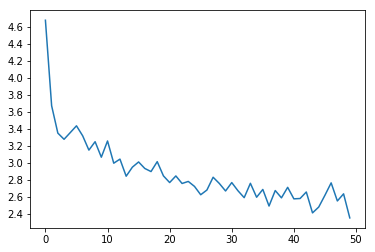

In [25]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)


if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [28]:
evaluateRandomly(attn_decoder1, encoder1)

> il est joueur .
= he s a gambler .


TypeError: forward() missing 1 required positional argument: 'encoder_outputs'

可视化注意力
---------------------

注意力机制的一个有用特性是其高度可解释的输出. 
由于它用于对输入序列的特定编码器输出进行加权,因此我们可以想象在每个时间步骤中查看网络最关注的位置.

您可以简单地运行 ``plt.matshow(attentions)``,将注意力输出显示为矩阵,
其中列是输入步骤,行是输出步骤.




In [29]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

KeyError: tensor(2)

为了获得更好的观看体验,我们将额外添加轴和标签:




In [30]:
def showAttention(input_sentence, output_words, attentions):
    # 用颜色条设置图形
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 设置轴
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 在每个打勾处显示标签
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

KeyError: tensor(75)

练习
=========

-  尝试使用不同的数据集

   -  另一种语言对
   -  人 → 机器 (例如. IOT 命令)
   -  聊天 → 响应
   -  问题 → 回答

-  用预先训练的词嵌入替换嵌入,例如word2vec或GloVe
-  尝试更多图层,更多隐藏单位和更多句子. 比较训练时间和结果.
-  如果您使用的翻译文件对中有两个相同的短语(``I am test \t I am test``),
   您可以使用它作为自动编码器.尝试这个:
   -  训练自编码器
   -  只保存编码器网络
   -  从那里训练一个新的解码器进行翻译


